In [9]:
import numpy as np
from doubleml import DoubleMLData, DoubleMLPLR
from sklearn.base import clone
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import scipy
import matplotlib.pyplot as plt

# Structural Functions

In [10]:
# Define functions
def r0(Z):
    return np.cos(np.sum(Z**2, axis=1))


def g0(Z):
    return np.prod(np.exp(Z), axis=1)


def f0(X):
    beta_0 = 1
    return X * beta_0

# Data Generation Function

In [11]:
def generate_data(N, NNp_ratio, p, q, seed=0):
    np.random.seed(seed)

    # E: R^12, with Ej ~ Uniform[0, 1/2]
    E = np.random.uniform(0, 1/q, size=(N+1, q+2))
    # Zij = (Ej+1 + rho * E12) / (1 + rho)
    rho = 1
    Zt = (E[:, 1:11] + rho * E[:, 11].reshape(-1, 1)) / (1 + rho)
    Z = Zt[1:, :]
    
    # target test point
    Z0 = Zt[0, :].reshape(1, -1)
    # expanded design
    Np = int(np.ceil(N / NNp_ratio))
    Eps = np.random.uniform(-np.sqrt(3)/q, np.sqrt(3)/q, (Np, q))
    Zp = Z0 + Eps

    # or Xi = r0(Zi) + Vi
    V = np.random.normal(0, 1, size=(N,))
    X = r0(Z) + V

    # Yi = f0(Xi) + g0(Z_i) + Ui
    U = np.random.normal(0, 1, size=(N,))
    Y = f0(X) + g0(Z) + U

    # Define data for double ML
    dml_data = DoubleMLData.from_arrays(Z, Y, X)
    

    return {"dml_data": dml_data, "Z0": Z0, "Zp": Zp}

# One-Round CI Coverage Function

In [12]:
def CI_r0_round(data, learner_type = "rf", alpha=0.05, seed=0):
    # Extract data
    dml_data = data["dml_data"]
    Z = dml_data.x
    X = dml_data.d
    Z0 = data["Z0"]
    Zp = data["Zp"]
    p = 1
    q = Z.shape[1]
    N = Z.shape[0]
    Np = Zp.shape[0]
    
    # Define learners
    if learner_type == "ols":
        learner = LinearRegression()
    elif learner_type == "rf":
        learner = RandomForestRegressor()
    elif learner_type == "nn":
        learner = MLPRegressor( 
            hidden_layer_sizes=(128, 64, 64, 128),
            activation="relu",
            solver="adam",
            max_iter=5000,
            random_state=seed,
        )
    else:
        raise ValueError("This type of learner is not supported yet.")
    
    # Define models
    g_hat = clone(learner)
    r_hat = clone(learner)
    
    # # DoubleML for beta_hat
    # dml = DoubleMLPLR(dml_data, ml_l=g_hat, ml_m=r_hat, n_folds=10)
    # dml.fit()
    # beta_hat = dml.coef
    
    # Fit r_hat and make predictions
    r_hat.fit(Z, X)
    X_hat = r_hat.predict(Z)
    X_hatp = r_hat.predict(Zp)
    
    # Correct biases
    mean_X_hatp = np.mean(X_hatp)
    delta = np.mean(X_hat - X)
    sigma_hat1 = np.mean((X_hat - X - delta) ** 2)
    sigma_hat2 = np.mean((X_hatp - mean_X_hatp) ** 2)

    def w_theta(alpha):
        return scipy.stats.norm.ppf(1 - alpha / (2 * p)) * np.sqrt(
            sigma_hat1 / N + sigma_hat2 / Np
        )

    def CI_r0(alpha):
        w = w_theta(alpha)
        lower = mean_X_hatp - delta - w
        upper = mean_X_hatp - delta + w
        return [lower, upper]
        
    def does_CI_cover(CI, truth):
        if truth > CI[0] and truth < CI[1]:
            return True
        else:
            return False

    return does_CI_cover(CI_r0(alpha), r0(Z0))

# Confidence Interval Coverage Graph

In [13]:
Ns = [1000, 2000, 3000, 4000, 5000]

In [14]:
coverage_probs_ols = []
coverage_probs_rf = []
coverage_probs_nn = []
for N in Ns:
    does_cover_ols = []
    does_cover_rf = []
    does_cover_nn = []
    for seed in range(500):
        # Generate data
        data = generate_data(N, NNp_ratio=0.1, p=1, q=10, seed=seed)
        # Construct CI for r0 and check coverage
        ## ols
        does_cover_ols.append(CI_r0_round(data, learner_type="ols", seed=seed))
        ## rf
        does_cover_rf.append(CI_r0_round(data, learner_type="rf", seed=seed))
        ## nn
        does_cover_nn.append(CI_r0_round(data, learner_type="nn", seed=seed))
    coverage_probs_ols.append(np.mean(does_cover_ols))
    coverage_probs_rf.append(np.mean(does_cover_rf))
    coverage_probs_nn.append(np.mean(does_cover_nn))
    

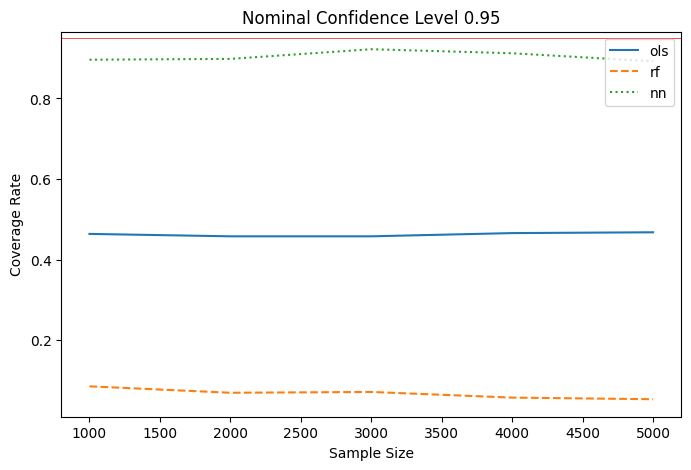

In [15]:
# Create the plot
plt.figure(figsize=(8, 5))  # Set figure size

# Plot multiple lines
plt.plot(Ns, coverage_probs_ols, label="ols", linestyle="-")   # Solid line
plt.plot(Ns, coverage_probs_rf, label="rf", linestyle="--")  # Dashed line
plt.plot(Ns, coverage_probs_nn, label="nn", linestyle=":")   # Dotted line

# Customize the plot
plt.xlabel("Sample Size")
plt.ylabel("Coverage Rate")
plt.title("Nominal Confidence Level 0.95")
plt.axhline(0.95, color="red", linewidth=0.5)  # Add horizontal line
plt.legend()  # Show legend

# Show the plot
plt.show()